In [1]:
# Total Exchange Flow (TEF) Calculation  (MacCready, 2011)
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import os, sys
sys.path.append(os.path.abspath('../Functions'))

In [2]:
# Load fields
Qsg = 700
hs = 12
State = xr.open_dataset('/Volumes/Extreme SSD/MITgcm outputs/qf' + str(format(Qsg,'03d')) + '_rot/state_' + str(format(hs,'03d')) + '.nc')
Grid = xr.open_dataset('/Volumes/Extreme SSD/MITgcm outputs/qf' + str(format(Qsg,'03d')) + '_rot/grid_' + str(format(hs,'03d')) + '.nc')
# Confine to the range of fjord
state = State.isel(X=range(120), Xp1=range(121), Y=range(30,39), T=range(1,len(State.T)))
grid = Grid.isel(X=range(120), Xp1=range(121), Y=range(30,39))


s = state.S.data.mean(2) # Salinity in T,Z,X
u = (state.U.data[:,:,:,1:].mean(2) + state.U.data[:,:,:,:-1].mean(2)) / 2 # Along channel velocity
ot = state.T.data # Time in seconds


x = grid.X.data
z = grid.Z.data
NY = len(state.Y)

HFacC = grid.HFacC.data.mean(1)
dyF = grid.dyF.data.mean(0)
drF = grid.drF.data

gridA = np.broadcast_to(drF[:, np.newaxis], HFacC.shape) * np.broadcast_to(dyF[np.newaxis, :], HFacC.shape) * HFacC # Grid Area
da = np.broadcast_to(gridA[np.newaxis:], u.shape)

  time 0 out of 336


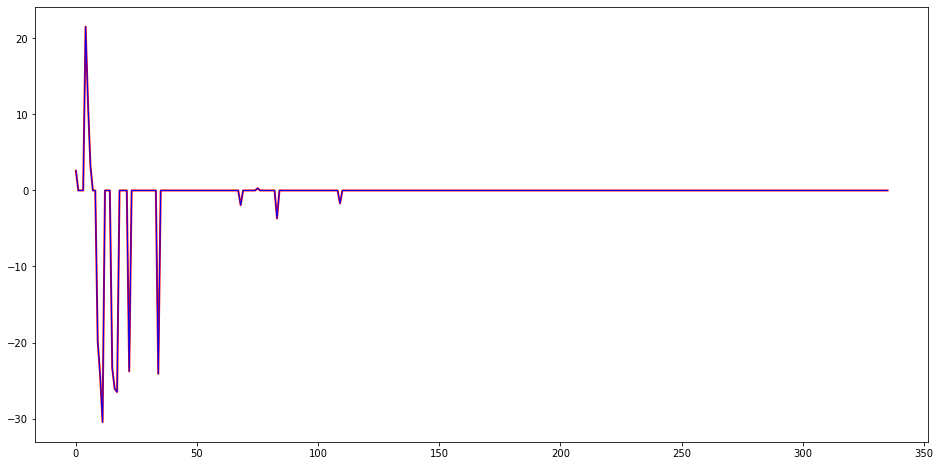

In [6]:

sma = np.ma.masked_where(s==0, s)
topo = np.ma.getmask(sma) # Masked Topography
uma = np.ma.MaskedArray(u, mask=topo)
q = uma * da
qs = q * sma
qs2 = q * sma * sma

xi = 53 # Location of the section to be processed

NT, NZ, NX = q.shape
# initialize intermediate results arrays for TEF quantities
sedges = np.linspace(0, 35, 1001) # original was 1001 used 5001 for Willapa
sbins = sedges[:-1] + np.diff(sedges)/2
NS = len(sbins) # number of salinity bins

# TEF variables
tef_q = np.zeros((NT, NS))
tef_vel = np.zeros((NT, NS))
tef_da = np.zeros((NT, NS))
tef_qs = np.zeros((NT, NS))
tef_qs2 = np.zeros((NT, NS))

# other variables
qnet = np.zeros(NT)
fnet = np.zeros(NT)
ssh = np.zeros(NT)
g = 9.81
rho = 1025

for tt in range(NT):
    if np.mod(tt,1000) == 0:
        print('  time %d out of %d' % (tt,NT))
        sys.stdout.flush()
            
    qi = q[tt,:,xi].squeeze()
    if isinstance(qi, np.ma.MaskedArray):
        qf = qi[qi.mask==False].data.flatten()
    else:
        qf = qi.flatten()
            
    si = sma[tt,:,xi].squeeze()
    if isinstance(si, np.ma.MaskedArray):
        sf = si[qi.mask==False].data.flatten()
    else:
        sf = si.flatten()
            
    dai = da[tt,:,xi].squeeze()
    if isinstance(dai, np.ma.MaskedArray):
        daf = dai[qi.mask==False].data.flatten()
    else:
        daf = dai.flatten()
            
    qsi = qs[tt,:,xi].squeeze()
    if isinstance(qsi, np.ma.MaskedArray):
        qsf = qsi[qi.mask==False].data.flatten()
    else:
        qsf = qsi.flatten()
            
    qs2i = qs2[tt,:,xi].squeeze()
    if isinstance(qs2i, np.ma.MaskedArray):
        qs2f = qs2i[qi.mask==False].data.flatten()
    else:
        qs2f = qs2i.flatten()
            
    # sort into salinity bins
    inds = np.digitize(sf, sedges, right=True)
    indsf = inds.copy().flatten()
    counter = 0
    for ii in indsf:
        tef_q[tt, ii-1] += qf[counter]
        tef_da[tt, ii-1] += daf[counter] # new
        tef_qs[tt, ii-1] += qsf[counter]
        tef_qs2[tt, ii-1] += qs2f[counter]
        counter += 1
        
    # also keep track of volume transport
    qnet[tt] = qf.sum()
        


# Calculating the velocity from transport/area
# NOTE: we require tef_q = tef_vel * tef_da
zmask = tef_da > 1 # Is this about the right number (1 m2)?
# Just avoiding divide-by-zero errors.
tef_vel[zmask] = tef_q[zmask] / tef_da[zmask]



plt.close('all')
fig = plt.figure(figsize=(16,8))
ax = fig.add_subplot(111)
iSc = (np.abs(sbins-25)).argmin()
ax.plot((ot-ot[0])/3600, tef_q[:,iSc], '-r', lw=2)
ax.plot((ot-ot[0])/3600, tef_vel[:,iSc]*tef_da[:,iSc], '-b', lw=1)
plt.show()

In [10]:
sbins.shape

(1000,)

In [ ]:

pad = 0

# subsample and cut off nans
tef_q_lp = tef_q[pad:-(pad+1):1, :]
tef_vel_lp = tef_vel[pad:-(pad+1):1, :]
tef_da_lp = tef_da[pad:-(pad+1):1, :]
tef_qs_lp = tef_qs[pad:-(pad+1):1, :]
tef_qs2_lp = tef_qs2[pad:-(pad+1):1, :]
ot = ot[pad:-(pad+1):1]
qnet_lp = qnet[pad:-(pad+1):1]

nt = len(ot)
ns = len(sedges)


# calculate Q(s) and Q_s(s), and etc.
Qv=np.zeros((nt, ns))
Vv=np.zeros((nt, ns))
Av=np.zeros((nt, ns))
Qs=np.zeros((nt, ns))
Qs2=np.zeros((nt, ns))
# Note that these are organized low s to high s, but still follow
# the TEF formal definitions from MacCready (2011)
Qv[:,:-1] = np.fliplr(np.cumsum(np.fliplr(tef_q_lp), axis=1))
Vv[:,:-1] = tef_vel_lp #np.fliplr(np.cumsum(np.fliplr(tef_vel_lp), axis=1))
Av[:,:-1] = tef_da_lp #np.fliplr(np.cumsum(np.fliplr(tef_da_lp), axis=1))
Qs[:,:-1] = np.fliplr(np.cumsum(np.fliplr(tef_qs_lp), axis=1))
Qs2[:,:-1] = np.fliplr(np.cumsum(np.fliplr(tef_qs2_lp), axis=1))

In [ ]:
ot, len(ot)

In [ ]:
import tef_fun_lorenz as tfl




# prepare arrays to hold multi-layer output
nlay = 30
QQ = np.nan * np.ones((NT, nlay))
VV = np.nan * np.ones((NT, nlay))
AA = np.nan * np.ones((NT, nlay))
SS = np.nan * np.ones((NT, nlay))
SS2 = np.nan * np.ones((NT, nlay))

for dd in range(nt):
            
    qv = Qv[dd,:]
    vv = Vv[dd,:]
    av = Av[dd,:]
    qs = Qs[dd,:]
    qs2 = Qs2[dd,:]
                
    Q_in_m, Q_out_m, V_in_m, V_out_m, A_in_m, A_out_m, s_in_m, s_out_m, s2_in_m, s2_out_m, div_sal, ind, minmax = tfl.calc_bulk_values(sedges,
            qv, vv, av, qs, qs2, print_info=False)
                        
        
   
    #print(' ind = %s' % (str(ind)))
    #print(' minmax = %s' % (str(minmax)))
    #print(' div_sal = %s' % (str(div_sal)))
    #print(' Q_in_m = %s' % (str(Q_in_m)))
    #print(' s_in_m = %s' % (str(s_in_m)))
    #print(' Q_out_m = %s' % (str(Q_out_m)))
    #print(' s_out_m = %s' % (str(s_out_m)))
        
    #fig = plt.figure(figsize=(12,8))
        
    #ax = fig.add_subplot(121)
    #ax.plot(Qv[dd,:], sedges,'.k')
    #min_mask = minmax=='min'
    #max_mask = minmax=='max'
    #print(min_mask)
    #print(max_mask)
    #ax.plot(Qv[dd,ind[min_mask]], sedges[ind[min_mask]],'*b')
    #ax.plot(Qv[dd,ind[max_mask]], sedges[ind[max_mask]],'*r')
    #ax.grid(True)
    #ax.set_title('Q(s) Time index = %d' % (dd))
    #ax.set_ylim(-.1,35.1)
    #ax.set_ylabel('Salinity')
        
    #ax = fig.add_subplot(122)
    #ax.plot(tef_q_lp[dd,:], sbins)
    #ax.grid(True)
    #ax.set_title('-dQ/ds')
        
    # save multi-layer output
    qq = np.concatenate((Q_in_m, Q_out_m))
    vv = np.concatenate((V_in_m, V_out_m))
    aa = np.concatenate((A_in_m, A_out_m))
    ss = np.concatenate((s_in_m, s_out_m))
    ss2 = np.concatenate((s2_in_m, s2_out_m))
    ii = np.argsort(ss)
    if len(ii)>0:
        ss = ss[ii]
        ss2 = ss2[ii]
        qq = qq[ii]
        vv = vv[ii]
        aa = aa[ii]
        NL = len(qq)
        QQ[dd, :NL] = qq
        VV[dd, :NL] = vv
        AA[dd, :NL] = aa
        SS[dd, :NL] = ss
        SS2[dd, :NL] = ss2

    dd+=1

In [ ]:
# separate positive and negative transports
QQp = QQ.copy()
QQp[QQ<=0] = np.nan
QQm = QQ.copy()
QQm[QQ>=0] = np.nan
        
# full transports
QQm = QQm
QQp = QQp
    
# form two-layer versions
Qp = np.nansum(QQp, axis=1)
QSp = np.nansum(QQp*SS, axis=1)
QS2p = np.nansum(QQp*SS2, axis=1)
Qm = np.nansum(QQm, axis=1)
QSm = np.nansum(QQm*SS, axis=1)
QS2m = np.nansum(QQm*SS2, axis=1)
    
# TEF salinities
Sp = QSp/Qp
Sm = QSm/Qm
    
# TEF variance
S2p = QS2p/Qp
S2m = QS2m/Qm
    
# adjust sign convention so that positive flow is salty
SP = np.nanmean(Sp)
SM = np.nanmean(Sm)
if SP > SM:
        
    # initial positive was inflow
    Sin = Sp
    Sout = Sm
    S2in = S2p
    S2out = S2m
    Qin = Qp
    Qout = Qm
    in_sign = 1
        
    QSin = QSp
    QSout = QSm
        
    QS2in = QS2p
    QS2out = QS2m
        
elif SM > SP:
    # initial postive was outflow
    Sin = Sm
    Sout = Sp
    S2in = S2m
    S2out = S2p
    Qin = -Qm
    Qout = -Qp
    in_sign = -1
        
    QSin = -QSm
    QSout = -QSp
        
    QS2in = -QS2m
    QS2out = -QS2p
else:
    print('ambiguous sign!!')

In [ ]:
Sin[275:-1].mean(), Sout[275:-1].mean(), Sout.shape

In [ ]:
import pickle